In [46]:
%load_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt

# Slef imports
from eclipses import *
from plotting import *
from cpop import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# Getting the Curve
eclipses = get_eclipses("kplr006545018.fits", "../data/combined/")
eclipses.head()

,time,duration,delta
0,1.000000,0.183911,2.002586
2,3.002586,0.183911,1.982151
4,4.984736,0.183911,2.002585
6,6.987321,0.183911,2.002584
8,8.989905,0.183911,2.002583


0.0 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0 153   0
 147   3]
0.006960806737889167 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0 153   0
 139  11]
0.013921613475778334 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0 153   0
  50 100]
0.0208824202136675 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0 153   0
  12 138]
0.02784322695155667 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0 152   1
   0 150]
0.03480403368944584 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0 152   1
   0 150]
0.041764840427335 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0 138  15
   0 150]
0.04872564716522417 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   6 147
   0 150]
0.05568645390311334 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   6 147
   0 150]
0.06264726064100251 [  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   3 1

False

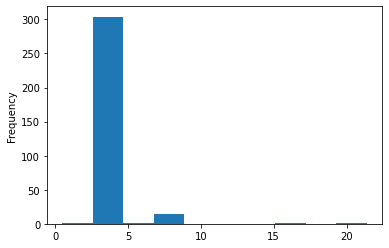

In [60]:
check, eclipse = remove_doubles(get_eclipses("kplr001026032.fits", "../data/combined/"), bin_cnt=1000)
eclipse['delta'].plot.hist()
check

<AxesSubplot:xlabel='time', ylabel='delta'>

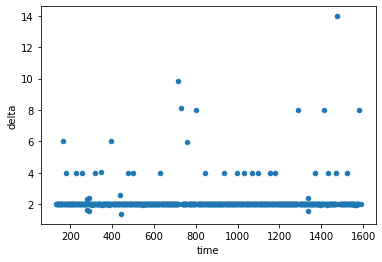

: 

In [ ]:
eclipse.plot.scatter(y='delta', x='time')